In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

import numpy as np
import random
import copy
import time
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


# from utils import CustomDataset, GANLoss, Vgg19
# from generator import AttU_Net
# from discriminator import Discriminator

from PIL import Image, ImageOps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/jupyter-hamin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [149]:
test_images_base_path = "/srv/data/hamin/OCR/test_imgs/b2"

#crop_base_path = "/srv/data/hamin/OCR/docproj/imgs/illumination/crop"
#scan_base_path = "/srv/data/hamin/OCR/docproj/imgs/illumination/scan"

In [150]:
i = 1
test_img_path = sorted(os.listdir(test_images_base_path))[i]

In [151]:
num_pixels_x, num_pixels_y, num_channels = 1024, 768, 3

In [152]:
im = Image.open(f"{test_images_base_path}/{test_img_path}")
im = ImageOps.exif_transpose(im)
im = im.resize((num_pixels_y, num_pixels_x))
im = np.array(im)


In [153]:
from models.u2net import U2NETP, U2NET

In [1]:
segment = U2NETP(out_ch=1).to(device)
scan_gen = U2NETP().to(device)
# generator = U2NET()

#generator = nn.DataParallel(generator)
#generator.to(device)

NameError: name 'U2NETP' is not defined

In [155]:
segmentation_model_path = './weights/mask_0326.pth'
generator_model_path = './weights/illumination_1024_fin.pth'

segment.load_state_dict(torch.load(segmentation_model_path))
scan_gen.load_state_dict(torch.load(generator_model_path))


<All keys matched successfully>

In [156]:
loader = transforms.Compose([transforms.ToTensor()])

In [157]:
image = loader(im).float()
image = image.unsqueeze(0).to(device)

In [158]:
with torch.no_grad():
    mask = segment(image)
    
mask_det = torch.permute(mask[0].detach().cpu(), (0, 2,3, 1)).numpy()
mask_det = mask_det>0.8

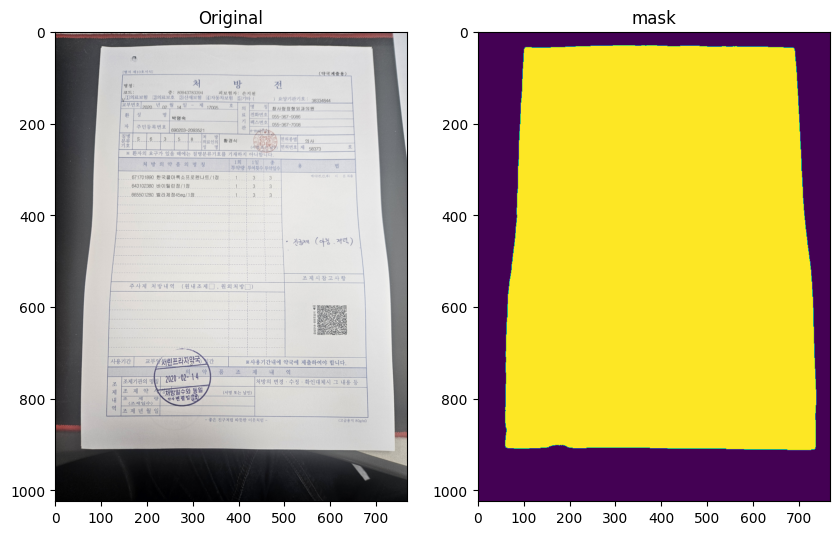

In [159]:
f, axarr = plt.subplots(1,2, figsize=(10,7))

i = -6
#cur_scan = scan_images[i]


axarr[0].imshow(im)
axarr[0].title.set_text('Original')

axarr[1].imshow(mask_det[0])
axarr[1].title.set_text('mask')

# axarr[2].imshow(cur_scan)
# axarr[2].title.set_text('scanned')

In [160]:
import cv2

In [161]:

def biggest_contour(contours, min_area):
    biggest = None
    max_area = 0
    biggest_n = 0
    approx_contour = None
    for n, i in enumerate(contours):
        area = cv2.contourArea(i)

        if area > min_area / 30:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
                biggest_n = n
                approx_contour = approx

    return biggest_n, approx_contour


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    pts = pts.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


# ## Find the exact (x,y) coordinates of the biggest contour and crop it out


def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    print(pts)
    rect = order_points(pts)
    print("---------")
    print(rect)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [162]:
mask_to_find = mask_det[0]

In [163]:
mask_to_find = np.array(mask_to_find*255).astype(np.uint8)

In [164]:
contours, hierarchy = cv2.findContours(mask_to_find, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

simplified_contours = []

for cnt in contours:
    hull = cv2.convexHull(cnt)
    simplified_contours.append(cv2.approxPolyDP(hull,
                                                0.001 * cv2.arcLength(hull, True), True))
biggest_n, approx_contour = biggest_contour(simplified_contours, 12192768)


In [165]:
warped = four_point_transform(im, approx_contour)

[[[103  35]]

 [[687  37]]

 [[731 911]]

 [[ 60 906]]]
---------
[[103.  35.]
 [687.  37.]
 [731. 911.]
 [ 60. 906.]]


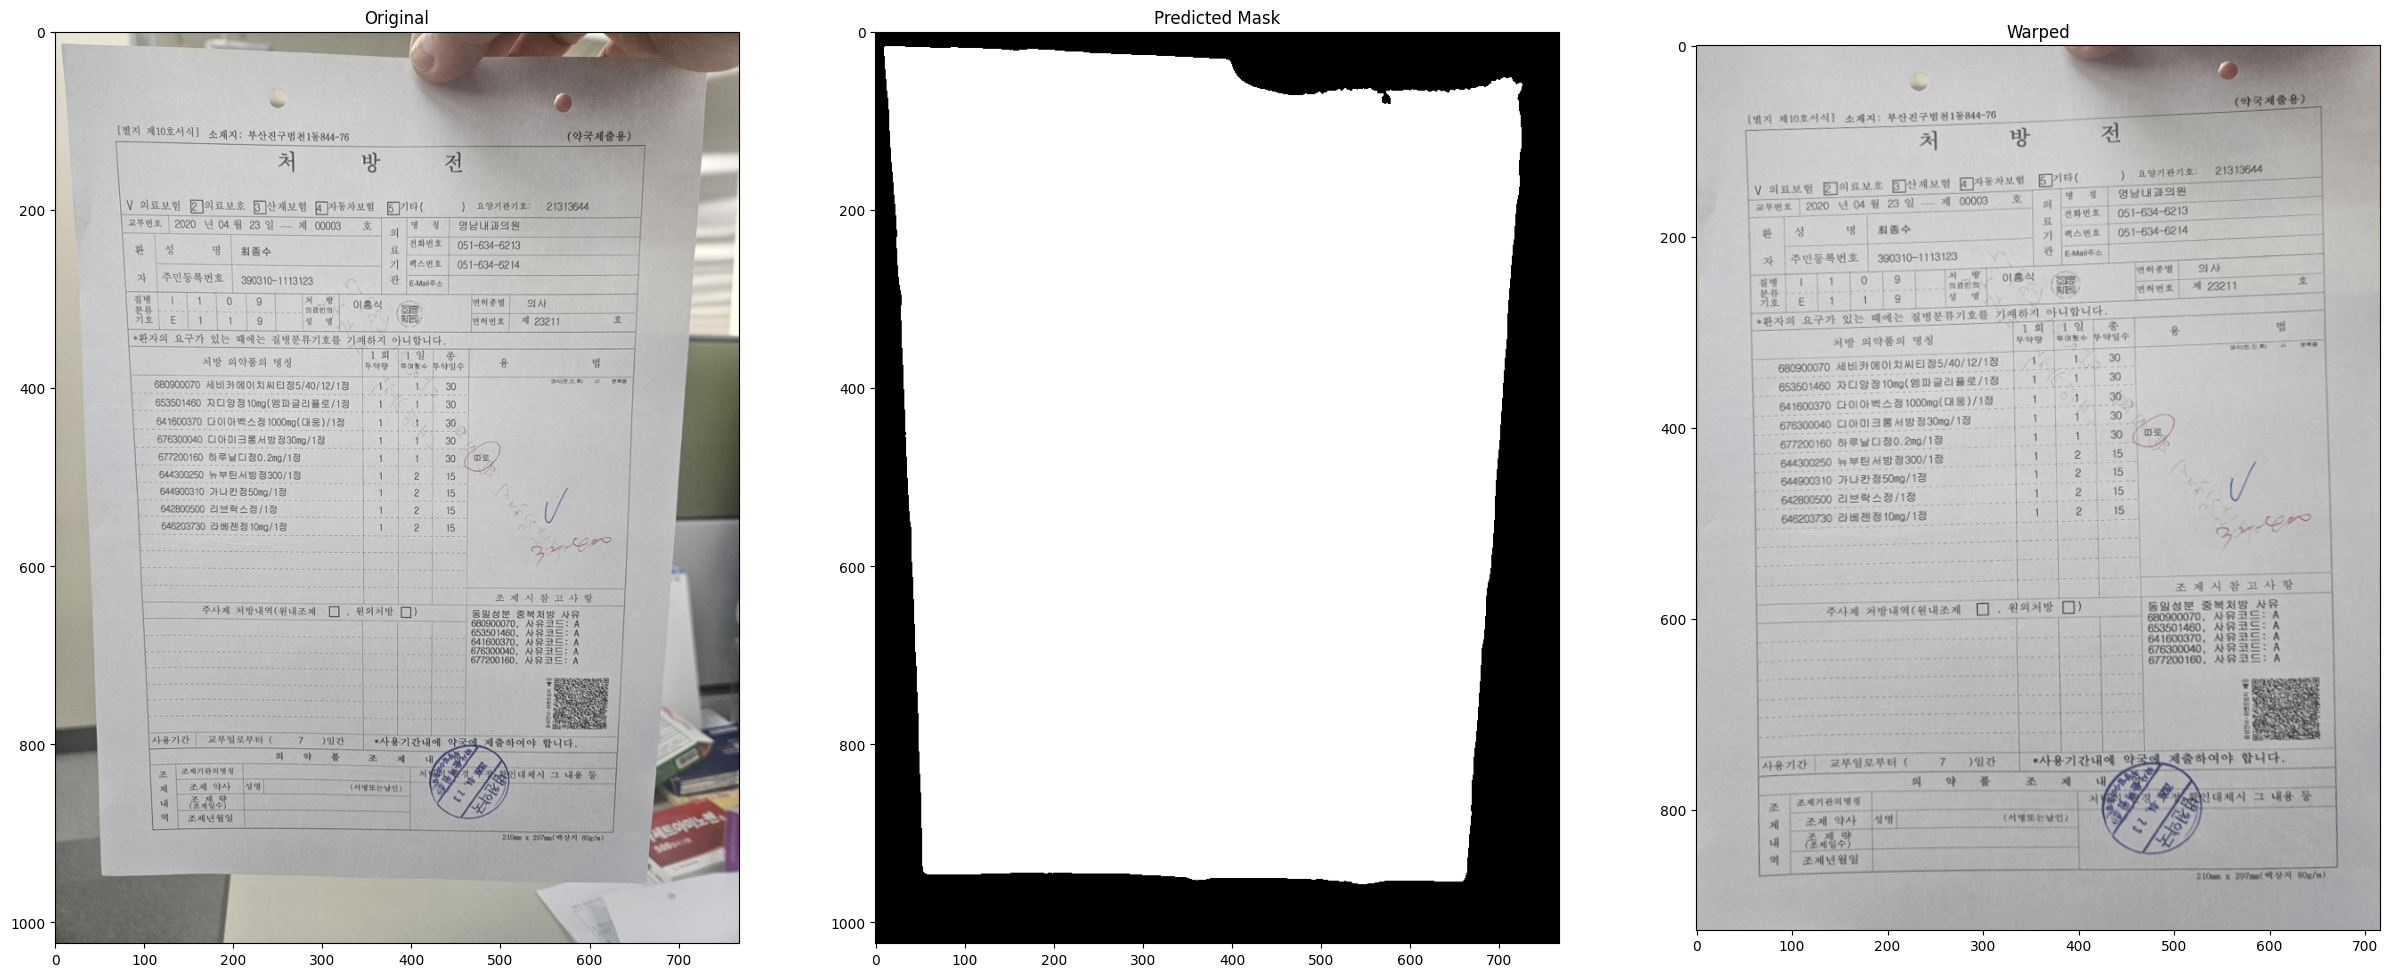

In [148]:
f, axarr = plt.subplots(1,3, figsize=(30,21))

i = -6
#cur_scan = scan_images[i]


axarr[0].imshow(im)
axarr[0].title.set_text('Original')

axarr[1].imshow(mask_det[0], cmap='gray')
axarr[1].title.set_text('Predicted Mask')

axarr[2].imshow(warped)
axarr[2].title.set_text('Warped')

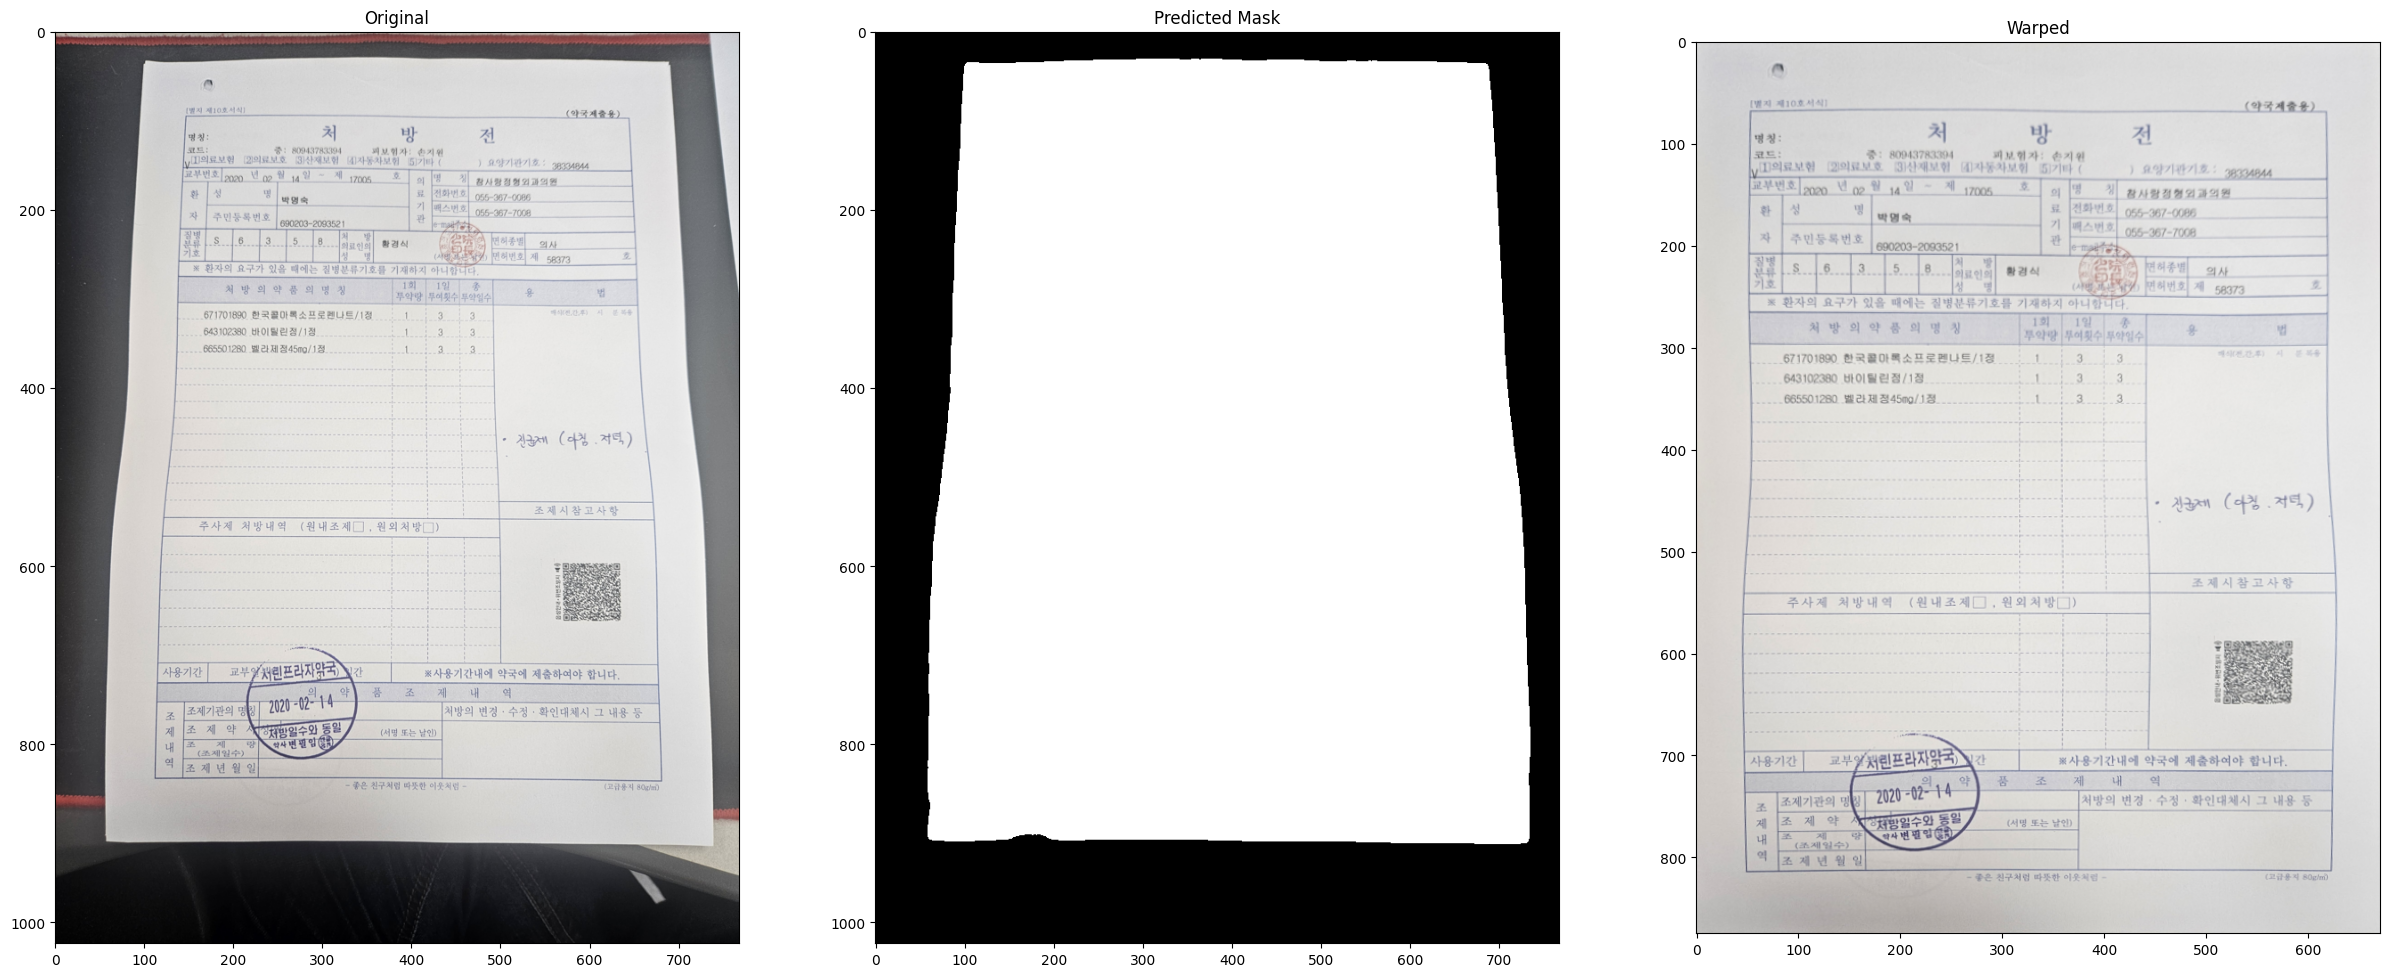

In [167]:
f, axarr = plt.subplots(1,3, figsize=(30,21))

i = -6
#cur_scan = scan_images[i]


axarr[0].imshow(im)
axarr[0].title.set_text('Original')

axarr[1].imshow(mask_det[0], cmap='gray')
axarr[1].title.set_text('Predicted Mask')

axarr[2].imshow(warped)
axarr[2].title.set_text('Warped')

In [46]:
image = loader(warped / 255).float()
image = image.unsqueeze(0).to(device)

In [47]:
with torch.no_grad():
    mask = scan_gen(image)

In [49]:
mask_det = torch.permute(mask[0].detach().cpu(), (0, 2,3, 1)).numpy()
#mask_det = mask_det>0.8

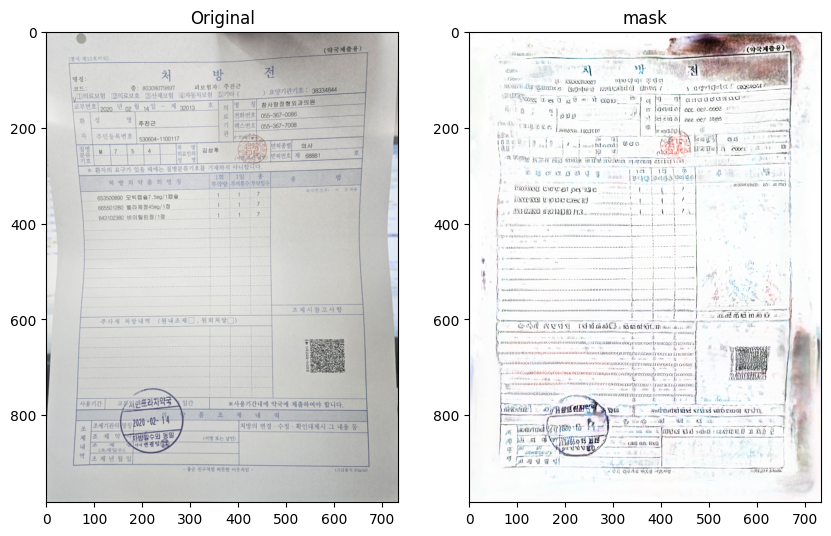

In [52]:
f, axarr = plt.subplots(1,2, figsize=(10,7))

i = -6
#cur_scan = scan_images[i]


axarr[0].imshow(warped)
axarr[0].title.set_text('Original')

axarr[1].imshow(mask_det[0])
axarr[1].title.set_text('mask')

# axarr[2].imshow(cur_scan)
# axarr[2].title.set_text('scanned')